In [1]:
import pandas as pd

wine = pd.read_csv('/Users/fatehkaran/datasets/winequality-white.csv', sep=';')

In [2]:
wine.loc[(wine.quality <= 5),'quality']= 0
wine.loc[(wine.quality > 5),'quality']= 1

In [3]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, classification_report

In [4]:
allData = wine

X = wine[['alcohol', 'volatile acidity']]

target = wine['quality']

y = target.astype(np.int)

X = X.values
y = y.values

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [6]:
%%time
# Set the the range of K 
neighbors = np.arange(1,60)

# Two arrays to store training and test accuracies
train_accuracy = np.empty(len(neighbors))
validation_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    
    # Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Fit the model
    knn.fit(X_train, y_train)
    
    
    # The "score" function returns the mean accuracy on the given train/test data and labels.
    # Note that "accuracy" may not be a good performance measure in a skewed data set
    # Thus, we need to do hyperparameter tuning by using better performance measures (e.g., f1 score, presision, recall)
    
    # Compute training accuracy 
    train_accuracy[i] = knn.score(X_train, y_train)
    
    # Compute validation accuracy using cross-validation
    
    scores = cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=5)
    
    validation_accuracy[i] = scores.mean()

CPU times: user 21.4 s, sys: 207 ms, total: 21.6 s
Wall time: 21.7 s


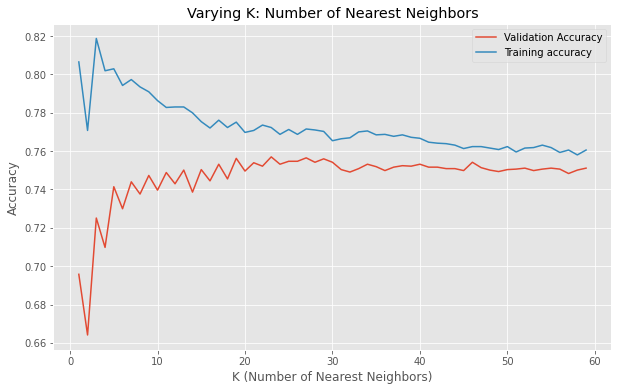

Optimal K:  23


In [7]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(10, 6))
plt.title('Varying K: Number of Nearest Neighbors')
plt.plot(neighbors, validation_accuracy, label='Validation Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('K (Number of Nearest Neighbors)')
plt.ylabel('Accuracy')
plt.show()



# Find the value of "K" that gives max validation accuracy
j = 0
max_val_accuracy = validation_accuracy[j]
max_k = 1

for i in neighbors:
    if(validation_accuracy[j] > max_val_accuracy):
        max_val_accuracy = validation_accuracy[j]
        max_k = i
    j +=1
    
print("Optimal K: ", max_k)

In [8]:
%%time

warnings.filterwarnings('ignore')

# The param_grid tells Scikit-Learn to evaluate all combinations of the hyperparameter values
param_grid = {'n_neighbors': np.arange(1,50), 'p': [1, 2, 10, 50, 100, 500, 1000], 
              'weights': ["uniform", "distance"]}

knn_clf = KNeighborsClassifier()

knn_cv = GridSearchCV(knn_clf, param_grid, scoring='f1', cv=5, verbose=3, n_jobs=-1)
knn_cv.fit(X_train, y_train)


params_optimal_knn = knn_cv.best_params_

print("Best Score: %f" % knn_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_knn)
print("\n")

Fitting 5 folds for each of 686 candidates, totalling 3430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 1008 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 1904 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   53.8s


Best Score: 0.829910
Optimal Hyperparameter Values:  {'n_neighbors': 27, 'p': 100, 'weights': 'uniform'}


CPU times: user 3.38 s, sys: 474 ms, total: 3.85 s
Wall time: 1min 1s


[Parallel(n_jobs=-1)]: Done 3423 out of 3430 | elapsed:  1.0min remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3430 out of 3430 | elapsed:  1.0min finished


In [9]:
# With the Mahalanobis distance metric only the brute force algorithm works
#knn = KNeighborsClassifier(weights=?, algorithm='brute', n_neighbors=?, metric = "mahalanobis", metric_params= {'V': ?})

# Minkowski distance metric based optimal model selected via hyperparameter tuning.
# The Minkowski distance based model (i.e., knn_cv) is already trained with the optimal hyperparameter values.
# We can use the optimal model (knn_cv) for prediction.
# Or we can use the optimal hyperparameter values to train a new model, as follows.

knn = KNeighborsClassifier(**params_optimal_knn)

knn.fit(X_train, y_train)

y_train_predicted = knn.predict(X_train)

train_accuracy_knn = np.mean(y_train_predicted == y_train)
print("\nTraining Accuracy: ", train_accuracy_knn)


Training Accuracy:  0.7718223583460949


In [10]:
# random indices for three data points from the training dataset
data1Index = 340
data2Index = 1230
data3Index = 2000

y_train_predicted_1 = knn.predict(X_train[data1Index].reshape(1, -1))
print("\nPredicted Class for the first data: %d" % y_train_predicted_1)

y_train_predicted_proba_1 = knn.predict_proba(X_train[data1Index].reshape(1, -1))
print("Predicted Class Probabilities for the first data: ", y_train_predicted_proba_1)


y_train_predicted_2 = knn.predict(X_train[data2Index].reshape(1, -1))
print("\nPredicted Class for the second data: %d" % y_train_predicted_2)

y_train_predicted_proba_2 = knn.predict_proba(X_train[data2Index].reshape(1, -1))
print("Predicted Class Probabilities for the second data: ", y_train_predicted_proba_2)



y_train_predicted_3 = knn.predict(X_train[data3Index].reshape(1, -1))
print("\nPredicted Class for the second data: %d" % y_train_predicted_3)

y_train_predicted_proba_3 = knn.predict_proba(X_train[data3Index].reshape(1, -1))
print("Predicted Class Probabilities for the second data: ", y_train_predicted_proba_3)


Predicted Class for the first data: 1
Predicted Class Probabilities for the first data:  [[0.22222222 0.77777778]]

Predicted Class for the second data: 1
Predicted Class Probabilities for the second data:  [[0.25925926 0.74074074]]

Predicted Class for the second data: 1
Predicted Class Probabilities for the second data:  [[0.2962963 0.7037037]]


In [11]:
# Scoring Parameter for Classification:
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
# Note: For a skewed data set "accuracy" might not be a good choice for scoring
scores = cross_val_score(knn, X_train, y_train, scoring='f1', cv=5)
print(scores)

print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.8428446  0.84532374 0.81899642 0.82965578 0.81272727]
F1 Score: 0.83 (+/- 0.03)


In [12]:
y_train_pred = cross_val_predict(knn, X_train, y_train, cv=5)

confusion_matrix(y_train, y_train_pred)

array([[ 642,  643],
       [ 309, 2324]])

In [13]:
precision = precision_score(y_train, y_train_pred) 
print("Precision = %f" % precision)

recall = recall_score(y_train, y_train_pred)
print("Recall = %f" % recall)


f1 = f1_score(y_train, y_train_pred)
print("F1 Score = %f" % f1)

Precision = 0.783283
Recall = 0.882643
F1 Score = 0.830000


In [14]:
# Get the 2nd column of the matrix of predicted probabilities for each data point
#    The 2nd column stores the probalities of the positive class
y_scores = cross_val_predict(knn, X_train, y_train, method="predict_proba", cv=5)[:, 1]


fpr, tpr, thresholds = roc_curve(y_train, y_scores)

print("\nFPR FPR & TPR for Various Threshold Values:")

print("FPR: ", fpr)
print("TPR: ", tpr)
print("\nThresholds: ", thresholds)


FPR FPR & TPR for Various Threshold Values:
FPR:  [0.         0.00700389 0.02101167 0.03424125 0.05214008 0.09338521
 0.15486381 0.19844358 0.23579767 0.29182879 0.34241245 0.37587549
 0.41011673 0.46614786 0.50038911 0.53307393 0.58132296 0.61945525
 0.67782101 0.73463035 0.79766537 0.88171206 0.92140078 0.96108949
 0.98210117 0.98832685 0.99844358 1.        ]
TPR:  [0.         0.04139765 0.15495632 0.25864033 0.32358526 0.39726548
 0.48803646 0.56893278 0.65058868 0.71439423 0.7535131  0.78883403
 0.81845803 0.85339916 0.88264337 0.89897455 0.91834409 0.9331561
 0.94644892 0.9551842  0.96961641 0.98328902 0.98974554 0.99734144
 0.99848082 0.99886062 0.99962021 1.        ]

Thresholds:  [2.         1.         0.96296296 0.92592593 0.88888889 0.85185185
 0.81481481 0.77777778 0.74074074 0.7037037  0.66666667 0.62962963
 0.59259259 0.55555556 0.51851852 0.48148148 0.44444444 0.40740741
 0.37037037 0.33333333 0.2962963  0.25925926 0.22222222 0.18518519
 0.14814815 0.11111111 0.07407407 

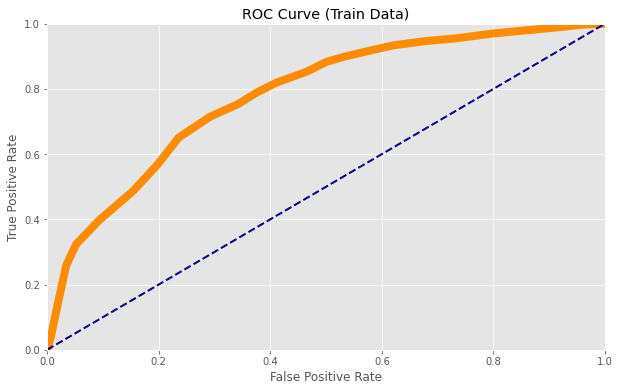

In [15]:
plt.style.use('ggplot')

fig = plt.figure(figsize=(10, 6))
def plot_roc_curve(fpr, tpr, label=None): 
    plt.plot(fpr, tpr, color='darkorange', linewidth=8, label=label) 
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.axis([0, 1, 0, 1])
    plt.title('ROC Curve (Train Data)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

In [16]:
# Area under ROC curve
roc_auc_score(y_train,y_scores)

0.7799002779744074

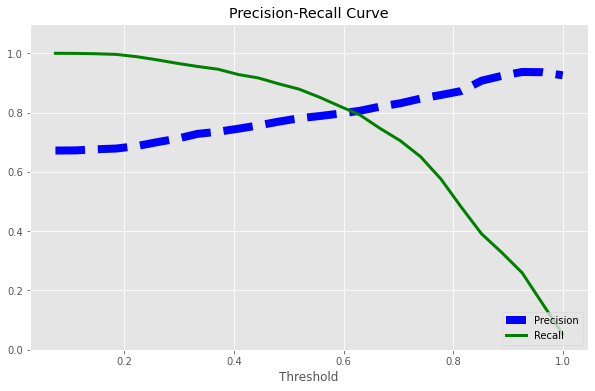

Optimal Threshold:  -1


In [17]:
plt.style.use('ggplot')

# Get the 2nd column of the matrix of predicted probabilities for each data point
#    The 2nd column stores the probalities of the positive class
y_scores = cross_val_predict(knn, X_train, y_train, method="predict_proba", cv=3)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)


fig = plt.figure(figsize=(10, 6))
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
    plt.plot(thresholds, precisions[:-1], "b--",  linewidth=8, label="Precision") 
    plt.plot(thresholds, recalls[:-1], "g-",  linewidth=3, label="Recall") 
    plt.xlabel("Threshold")
    plt.legend(loc="lower right")
    plt.title('Precision-Recall Curve')
    #plt.xlim([0, 1])
    plt.ylim([0, 1.1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()


threshold_optimal = -1
for i in range(len(precisions)):
    if(precisions[i] == recalls[i]):
        threshold_optimal = thresholds[i]

print("Optimal Threshold: ", threshold_optimal)

In [18]:
print("Performance Measures Based on the Default Threshold:\n")


y_train_pred = cross_val_predict(knn, X_train, y_train, cv=5)

# Precision, Recall, F1 Score and Confusion Matrix for the Default Threshold 0.5
precision_train = precision_score(y_train, y_train_pred) 
print("Precision (Default Threshold 0.5) = %f" % precision_train)

recall_train = recall_score(y_train, y_train_pred)
print("Recall (Default Threshold 0.5) = %f" % recall_train)


f1_train = f1_score(y_train, y_train_pred)
print("F1 Score (Default Threshold 0.5) = %f" % f1_train)

print("Confusion Matrix (Default Threshold 0.5)\n", confusion_matrix(y_train, y_train_pred))


print("\n-------------------------------------------------------\n")
print("Performance Measures Based on the Optimal Threshold (from Precision-Recall Curve):")

# Precision, Recall, F1 Score and Confusion Matrix for different threshold

t = threshold_optimal # optimal threshold from precision-recall curve 

# Compute predictions based on new t by using the following method:
#  - Get the probability of the positive class from the 2nd column [:, 1]
#  - If that probability is greater than or equal to t, then the test data belongs to the positive class
y_train_predicted_new = (cross_val_predict(knn, X_train, y_train, method="predict_proba", cv=3)[:,1] > t).astype(int)


precision = precision_score(y_train, y_train_predicted_new) 
print("\nPrecision (Threshold %.2f) = %f" % (t, precision))

recall = recall_score(y_train, y_train_predicted_new)
print("Recall (Threshold %.2f) = %f" % (t, recall))


f1 = f1_score(y_train, y_train_predicted_new)
print("F1 Score = (Threshold %.2f) = %f" % (t, f1))


print("Confusion Matrix (Threshold %.2f)" %  t) 
print(confusion_matrix(y_train, y_train_predicted_new))

Performance Measures Based on the Default Threshold:

Precision (Default Threshold 0.5) = 0.783283
Recall (Default Threshold 0.5) = 0.882643
F1 Score (Default Threshold 0.5) = 0.830000
Confusion Matrix (Default Threshold 0.5)
 [[ 642  643]
 [ 309 2324]]

-------------------------------------------------------

Performance Measures Based on the Optimal Threshold (from Precision-Recall Curve):

Precision (Threshold -1.00) = 0.672027
Recall (Threshold -1.00) = 1.000000
F1 Score = (Threshold -1.00) = 0.803847
Confusion Matrix (Threshold -1.00)
[[   0 1285]
 [   0 2633]]


In [19]:
# The accuracy of the model
test_accuracy_knn = knn.score(X_test, y_test)
print("\nTest Accuracy: ", test_accuracy_knn)


# No. of Correct Predictions
y_test_predicted = knn.predict(X_test)
print("\nNo. of correct predictions (Test): %d/%d" % (np.sum(y_test_predicted == y_test), len(y_test)))



# Confusion Matrix
print("\nConfusion Matrix (Test Data):\n", confusion_matrix(y_test, y_test_predicted))


Test Accuracy:  0.7214285714285714

No. of correct predictions (Test): 707/980

Confusion Matrix (Test Data):
 [[145 210]
 [ 63 562]]


In [20]:
precision = precision_score(y_test, y_test_predicted) 
print("Precision = %f" % precision)

recall = recall_score(y_test, y_test_predicted)
print("Recall = %f" % recall)


f1 = f1_score(y_test, y_test_predicted)
print("F1 Score = %f" % f1)

Precision = 0.727979
Recall = 0.899200
F1 Score = 0.804581


In [21]:
# Get the 2nd column of the matrix of predicted probabilities for each data point
#    The 2nd column stores the probalities of the positive class
y_scores_test = cross_val_predict(knn, X_test, y_test, method="predict_proba", cv=3)[:, 1]

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_scores_test)


print("\nFPR FPR & TPR for Various Threshold Values:")
print("FPR: ", fpr_test)
print("TPR: ", tpr_test)
print("\nThresholds: ", thresholds_test)


FPR FPR & TPR for Various Threshold Values:
FPR:  [0.         0.0084507  0.01690141 0.03380282 0.03380282 0.07042254
 0.10422535 0.15492958 0.18309859 0.21126761 0.26478873 0.31549296
 0.38309859 0.45352113 0.50704225 0.57464789 0.64225352 0.68450704
 0.74929577 0.7943662  0.87042254 0.92676056 0.97464789 0.9943662
 1.        ]
TPR:  [0.     0.0464 0.1632 0.232  0.2816 0.3472 0.408  0.4672 0.5248 0.5936
 0.648  0.704  0.7536 0.8208 0.856  0.8768 0.9008 0.9184 0.9408 0.952
 0.9664 0.9872 1.     1.     1.    ]

Thresholds:  [2.         1.         0.96296296 0.92592593 0.88888889 0.85185185
 0.81481481 0.77777778 0.74074074 0.7037037  0.66666667 0.62962963
 0.59259259 0.55555556 0.51851852 0.48148148 0.44444444 0.40740741
 0.37037037 0.33333333 0.2962963  0.25925926 0.22222222 0.18518519
 0.14814815]


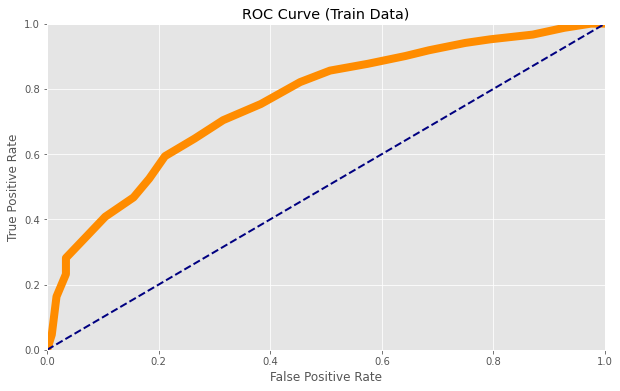

In [22]:
plt.style.use('ggplot')

fig = plt.figure(figsize=(10, 6))
plot_roc_curve(fpr_test, tpr_test)
plt.show()

In [23]:
# Area under ROC curve
roc_auc_score(y_test,y_scores_test)

0.7585870422535211

In [24]:
pd.crosstab(y_test, y_test_predicted, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,145,210,355
1,63,562,625
All,208,772,980


In [25]:
print(classification_report(y_test,y_test_predicted))

              precision    recall  f1-score   support

           0       0.70      0.41      0.52       355
           1       0.73      0.90      0.80       625

    accuracy                           0.72       980
   macro avg       0.71      0.65      0.66       980
weighted avg       0.72      0.72      0.70       980

